<a href="https://colab.research.google.com/github/tiyu0203/fml/blob/master/FML_proj4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Frequentist Machine Learning**

**Assignment 4**

**Jonathan Lam, Tiffany Yu, Harris Paspuleti**

---
## Defining the Models using XGBoost

In [ ]:
#Setting up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# sklearn utility functions for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

class XGBoostClassifier:

    def __init__(self, X, y, feature_names):

        self.feature_names = feature_names

        # split into test and training datasets
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(X, y, \
                             test_size=0.2, \
                             random_state=np.random.randint(0, 100), \
                             shuffle=True)

        # standardize features
        self.X_train = StandardScaler().fit_transform(self.X_train)
        self.X_test = StandardScaler().fit_transform(self.X_test)
        
        # turn into xgboost dmatrices
        self.train_dm = xgb.DMatrix(pd.DataFrame(data=self.X_train, \
                                                 columns=feature_names), \
                                                 label=self.y_train)
        self.test_dm = xgb.DMatrix(pd.DataFrame(data=self.X_test, \
                                                columns=feature_names), \
                                                label=self.y_test)

    # train the model, and show evaluation statistics on the test dataset
    def train_eval(self, num_rounds, parms):
        eval_list = [(self.train_dm, 'train'), (self.test_dm, 'eval')]
        xgb_classifier = xgb.XGBRegressor()
        
        # grid search to find the optimal parameters
        xgb_grid = GridSearchCV(xgb_classifier,
                                parms,
                                cv=2,
                                n_jobs=5,
                                verbose=True)

        xgb_grid.fit(self.X_train, self.y_train)
        print(f'Best score from grid search: {xgb_grid.best_score_}')
        print(f'Best parameters from grid search: {xgb_grid.best_score_}')
        self.progress = {}        
        self.xgb_classifier = xgb.train(xgb_grid.best_params_,
                                        self.train_dm,
                                        num_boost_round=num_rounds,
                                        evals=eval_list,
                                        evals_result=self.progress,
                                        early_stopping_rounds=100)

    # plot average absolute error vs. iterations; assumes model has 
    # already been trained
    def plot_aae(self):
        plt.plot(self.progress['train']['mae'])
        plt.plot(self.progress['eval']['mae'])
        plt.legend(['Train Error', 'Test Error'])
        plt.title('Training and Test Absolute Error')
        plt.ylim([0, 1])
        plt.xlim([0, len(self.progress['train']['mae'])])
        plt.ylabel('Absolute Error')
        plt.xlabel('Iterations')
        plt.show()

    # plot relative importance plot; assumes model has already been trained
    def plot_importance(self):
        xgb.plot_importance(self.xgb_classifier)
        plt.show()

---
## Running the Models

### California housing Datset


> First, select one of the datasets from section 10.14 of the test(either California Housing or New Zealand Fish) and replicate the analysis, including the plots. You don't have to do the maps.

In [ ]:
# california housing dataset from sklearn
from sklearn.datasets import fetch_california_housing
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

# create classifier
classifier = XGBoostClassifier(X, y, cal_housing.feature_names)

# train classifier
parms = {
    'nthread':        [4],
    'objective':      ['reg:squarederror'], # textbook uses Huber loss;
                                            # colab doesn't have newest xgboost
                                            # so we just use reg:squarederror
    'learning_rate':  [0.1, 0.3, 0.5],
    'max_depth':      [5, 6, 7],
    'n_estimators':   [100, 200],
    'eval_metric':    ['mae'],              # mean absolute error
}
classifier.train_eval(800, parms)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  36 out of  36 | elapsed:   58.8s finished


Best score from grid search: 0.8255871582202914
Best parameters from grid search: 0.8255871582202914
[0]	train-mae:1.41355	eval-mae:1.4289
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[1]	train-mae:1.27506	eval-mae:1.29848
[2]	train-mae:1.15248	eval-mae:1.18075
[3]	train-mae:1.04369	eval-mae:1.07777
[4]	train-mae:0.948501	eval-mae:0.987476
[5]	train-mae:0.862609	eval-mae:0.907423
[6]	train-mae:0.787725	eval-mae:0.838907
[7]	train-mae:0.723328	eval-mae:0.778597
[8]	train-mae:0.666402	eval-mae:0.728005
[9]	train-mae:0.615871	eval-mae:0.682306
[10]	train-mae:0.572165	eval-mae:0.642676
[11]	train-mae:0.534386	eval-mae:0.609035
[12]	train-mae:0.502055	eval-mae:0.579536
[13]	train-mae:0.473284	eval-mae:0.553699
[14]	train-mae:0.448884	eval-mae:0.533653
[15]	train-mae:0.427828	eval-mae:0.515173
[16]	train-mae:0.410277	eval-mae:0.500721
[17]	train-mae:0.393812	eval-mae:0.487391
[18]	train-mae:0.380

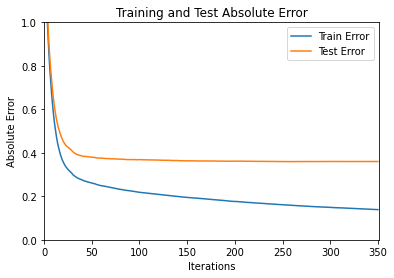

In [ ]:
# plot aae over iterations  
classifier.plot_aae()

The graph above shows the absolute error as a function of number of iterations for the California housing data. The test error has a steep decrease in the beginning and then levels off to a constant error as the iterations increase (to around .32). Since the average absolute error levels to a constant, that means we wouldn't need to run that many iterations as long as it's not too small. For the training error, with more iterations the absolute error continues to decrease as there are more iterations. In order to minimize the absolute train error, we would have to increase the amount of iterations. We included early stopping for 100 rounds, which means it will continue to train until the eval-mae hasn't improved. Since we had about 800 iterations and the graph stopped at around 350, that means after 350 iterations the eval-mae stopped improving. 

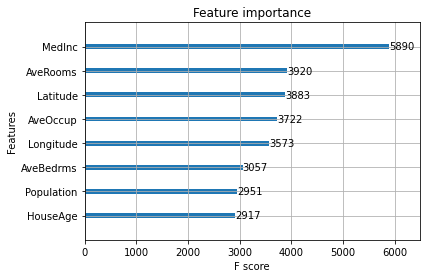

In [ ]:
# plot relative feature importance
classifier.plot_importance()

The graph above shows the relative variable importances for each of the eight predictor variables. The feature with the largest bar is the feature that is the most relavant predictor, which is the median income in the california housing dataset. This would make sense because the amount of income a person has dictates how much they can afford and is one of the main deciding factors of buying a house. Average rooms, lattitude, average occupancy, and longitude have a little more than half of the relavancy as the median income, which means those features are some what influencial. Since average bedrooms, population, and house age have the least relavency that means they are less influential. Each feature is plotted by the F-score, which is a metric that sums up how many times each feature is split on. 


### Prostate Cancer Datset

Next, select a dataset of your choice and perform a similar analysis. You can perform classification or regresssion, your choice. This should be a more complicated, and if you want, messier, dataset than the ones we've looked at so far. Use the built-in functions that come with the xgboost package to tune the model and optimize your performance, and determine the feature importance.  As this assignment is more focused on using a library, I will be expecting a more thoughtful analysis of the results.

In [ ]:
# dataset downloaded from kaggle:
#info at https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.info.txt
prostate_df = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data',
                          delimiter='\t',
                          usecols=list(np.arange(0,10)), index_col=0)

X = prostate_df.iloc[:,:8]
y = prostate_df.iloc[:,8]
cols = prostate_df.drop(columns='lpsa').columns

# create classifier
classifier = XGBoostClassifier(X, y, cols)

# train classifier
parms = {
    'nthread':        [4],
    'objective':      ['reg:squarederror'],
    'learning_rate':  [0.1, 0.3, 0.5],
    'max_depth':      [5, 6, 7],
    'n_estimators':   [100, 200],
    'eval_metric':    ['mae'],
}
classifier.train_eval(800, parms)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Best score from grid search: 0.2160471358305293
Best parameters from grid search: 0.2160471358305293
[0]	train-mae:1.11413	eval-mae:1.17446
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
[1]	train-mae:0.649131	eval-mae:0.838229
[2]	train-mae:0.392655	eval-mae:0.732274
[3]	train-mae:0.276623	eval-mae:0.71273
[4]	train-mae:0.199264	eval-mae:0.709028
[5]	train-mae:0.156691	eval-mae:0.731083
[6]	train-mae:0.125482	eval-mae:0.701102
[7]	train-mae:0.09729	eval-mae:0.704725
[8]	train-mae:0.073057	eval-mae:0.705814
[9]	train-mae:0.063983	eval-mae:0.701403
[10]	train-mae:0.056519	eval-mae:0.705187
[11]	train-mae:0.04763	eval-mae:0.6978
[12]	train-mae:0.037349	eval-mae:0.69685
[13]	train-mae:0.033738	eval-mae:0.696899
[14]	train-mae:0.026227	eval-mae:0.693622
[15]	train-mae:0.023187	eval-mae:0.693349
[16]	train-mae:0.019085	eval-mae:0.694894
[17]	train-mae:0.016421	eval-mae:0.696527
[18]	train-mae:0.01

[Parallel(n_jobs=5)]: Done  36 out of  36 | elapsed:    3.3s finished


[20]	train-mae:0.011494	eval-mae:0.695116
[21]	train-mae:0.009726	eval-mae:0.694292
[22]	train-mae:0.007585	eval-mae:0.695963
[23]	train-mae:0.006155	eval-mae:0.695878
[24]	train-mae:0.005161	eval-mae:0.696383
[25]	train-mae:0.00429	eval-mae:0.696002
[26]	train-mae:0.003896	eval-mae:0.696021
[27]	train-mae:0.003617	eval-mae:0.696297
[28]	train-mae:0.003245	eval-mae:0.696552
[29]	train-mae:0.002886	eval-mae:0.69676
[30]	train-mae:0.002621	eval-mae:0.696799
[31]	train-mae:0.002278	eval-mae:0.696976
[32]	train-mae:0.001871	eval-mae:0.697361
[33]	train-mae:0.001411	eval-mae:0.697242
[34]	train-mae:0.001298	eval-mae:0.697349
[35]	train-mae:0.001216	eval-mae:0.69735
[36]	train-mae:0.001041	eval-mae:0.697333
[37]	train-mae:0.000888	eval-mae:0.69721
[38]	train-mae:0.000796	eval-mae:0.697195
[39]	train-mae:0.000755	eval-mae:0.697176
[40]	train-mae:0.000755	eval-mae:0.697175
[41]	train-mae:0.000754	eval-mae:0.697175
[42]	train-mae:0.000754	eval-mae:0.697174
[43]	train-mae:0.000754	eval-mae:0.697

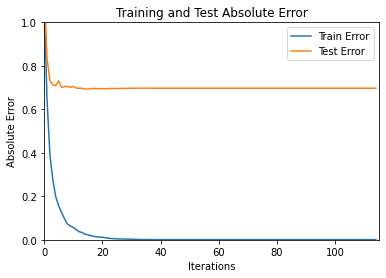

In [ ]:
# plot aae over iterations  
classifier.plot_aae()

The graph above shows the absolute error as a function of number of iterations for the prostate dataset. The test error has a steep increase and a slight incrase in the beginning before leveling out to a constant error as the iterations increase (to around.697). Since the absolute error levels off to a constant, that means we don't need to run too many iterations. For the training error, unlike the california housing dataset, it has a steep decrease for the train absolute error and levels off near 0 as the iterations increase. So for botht the train and test absolute error, we don't need to run too many iterations. Early stopping rounds were used, which means it will train until eval-mae hasn't improved in 100 rounds. The amount of iterations were 800, since the graph only goes up to 100, that means after 100 iterations, eval-mae stopped improving. 


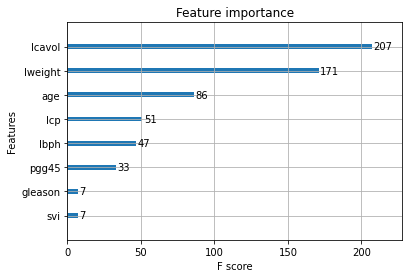

In [ ]:
# plot relative feature importance
classifier.plot_importance()

The graph above shows the relative variable importance for each of the eight predictor variables. The feature with the largest bar is the feature that is the most relavant predictor, which is lcavol. Lcavol is the log of cancer volume, which makes sense that a large amount of cancer volume would be a big indicator if a person has prostate cancer. The second highest feature is lweight, which is the log of the person's weight. The features with the least relavancy, which means those features have the least impact , were gleason and svi. Gleason is gleason score and svi is seminal veicle invasion. Each feature is plotted by the F-score, which is a metric that sums up how many times each feature is split on. 
